# Беспроводные датчики радиочастотной идентификации объектов (Radio Frequency IDentification marks) <a id="intro">

## 1. Описание проекта

**Целью данного проекта** является разработка пайплайна для автоматической обработки результатов измерений [беспроводных датчиков радиоидентификации (РЧИД-радиометок)](https://avangard.org/catalog/sistemy-radiochastotnoy-identifikatsii-rchid-rfid-na-poverkhnostnykh-akusticheskikh-volnakh-pav/sistema-radiochastotnoy-identifikatsii-i-pozitsionirovaniya-zheleznodorozhnogo-i-vnutrishakhtnogo-tr/), изготовленных в Центре микросистемотехники ОАО "Авангард".

В процессе производства на поверхности тонкой пластины черного ниобата лития толщиной 0.5 мм и диаметром 100 мм (рис. 1) методами фотолитографии и вакуумного напыления наносят металлические электроды. Минимальная ширина элемента составляет $350\pm30$ нм (нанометров). Затем пластина с помощью ~наноболгарки~ установки дисковой резки разрезается на отдельные радиометки (рис. 2), всего на пластине помещается 825 таких радиометок. На финишной операции функционального контроля на каждую сформированную радиометку, обладающую уникальным id-номером, с помощью зондовой станции подается СВЧ сигнал частотой 2.45 ГГц и измеряются её выходные характеристики.

**Основные задачи пайплана:**
1. Подготовка карты годных радиометок.
1. Построение распределений характеристик радометок для анализа причин брака.
1. Генерация pdf-отчета с id годных меток и сводной таблицей их характеристик.

  
<table>
    <tr>
        <td> <img src="black_LN.jpg" alt="Drawing" style="width: 200px;"/> </td>
        <td> <img src="black_LN.jpg" alt="Drawing" style="width: 200px;"/> </td>
    </tr>
</table>



## Содержание <a id="contents">

1. [Описание проекта](#intro)  
2. [Требования ТЗ к радиометкам ](#requirements)  
3. [Чтение данных из лог-файлов обрудования и предобработка](#reading)  
  - 3.1 [Данные с функциональными характеристиками радиометок с зондовой станции](#zond)
  - 3.2 [Данные с технологическими характеристиками при экспонировании каждой радиометки на степпере](#stepper)
  - 3.3 [Объединение датасетов с фунциональными и технологическим характеристиками](#merge)
      
    
4. [Разметка данных и построение карты годных радиометок](#yield_ratio)
  - 4.1 [Разметка данных (годные "1", бракованные "0")](#classes)
  - 4.2 [Карта годных радиометок](#yield_map)

    
5. [Анализ распределений ключевых характеристик](#EDA)  
  - 5.1 [Распределения характеристик](#distributions) 
  - 5.2 [Сводная таблица характеристик (годные VS бракованные)](#pivot_table) 
  - 5.3 [Тепловая карта корреляций технологических и функциональных параметров](#heat_map) 
    

6. [Статистическа проверка гипотез](#etching)
    
7. [Выгрузка сводного pdf-отчета (latex)](#report)  

## 2. Требования ТЗ к радиометкам (критерии годности) <a id="requirements">

<table width="100%" border="1" cellpadding="4" cellspacing="0">
   <caption> Характеристики радиометок </caption>
    <tr>
        <td> <b> Параметр </td>
        <td> <b> Обозначение </td>
        <td> <b> Допустимые значения </td>
        <td> <b> Единица измерения </td>
    </tr>
    <tr>
        <td> <b> Индентификационный номер</td>
        <td> id </td>
        <td> от 1 до 825 </td>
        <td> - </td>
    </tr>
    <tr>
        <td> <b> Рабочая частота №1 </td>
        <td> $f_1$ </td>
        <td> от 2.455 до 2.462 </td>
        <td> GHz </td>
    </tr>
    <tr>
        <td> <b> Рабочая частота №2 </td>
        <td> $f_2$ </td>
        <td> от 2.453 до 2.460 </td>
        <td> GHz </td>
    </tr>
    <tr>
        <td> <b> Рабочая частота №3 </td>
        <td> $f_3$ </td>
        <td> от 2.451 до 2.461 </td>
        <td> GHz </td>
    </tr>    
    <tr>
        <td> <b> Максимально допустимое ослабление сигнала  </td>
        <td> $A_{max}$ </td>
        <td> не более 35 </td>
        <td> dB </td>
    </tr>
    <tr>
        <td> <b> Неравномерность затухания в полосе пропускания  </td>
        <td> $\Delta A$ </td>
        <td> не более 5 </td>
        <td> dB </td>
    </tr>
    <tr>
        <td> <b> Минимальный размах затухания </td>
        <td><b> $A_{spread}$ </td>
        <td>  не менее 10 </td>
        <td> dB</td>
    </tr>
    <tr>
        <td> <b> Ширина полосы пропускания (bandwidth) </td>
        <td><b> $bw_1, bw_2, bw_3$ </td>
        <td>  не менее 95 </td>
        <td> MHz</td>
    </tr>
    <tr>
        <td> <b> Время отклика </td>
        <td> $\tau_1, \tau_2, \tau_3$ </td>
        <td> требования <br> не предъявляются </td>
        <td> нс </td>
    </tr>
</table>

In [1]:
F1_MIN, F1_MAX = 2.455, 2.462  # Диапазон рабочих частот
F2_MIN, F2_MAX = 2.453, 2.460  
F3_MIN, F3_MAX = 2.451, 2.461  

A_LIMIT = 35  # Максимально допустимое ослабление сигнала 
A_ROUGHNESS = 5 # Максимально допустимая неравномерность сигнала
A_SPREAD = 10  # Минимальный размах затухания
BW_LIMIT = 95  # Минимально допустимая ширина полосы
CHIP_TOTAL = 825 # всего на пластине 825 меток

## 3. Чтение данных из лог-файлов оборудования  и их предобработка <a id="reading">
[к содержанию](#contents)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

from IPython.display import Markdown as md
pd.options.display.max_columns = 9999 

import subprocess

import scipy.stats as st

### 3.1 Данные с функциональными характеристиками радиометок с зондовой станции <a id="zond">

In [3]:
zond = pd.read_csv('zondreport_base.txt', sep='\t', header = None)
zond.columns=['id', 'tau1', 'tau2', 'tau3', 'a1', 'a2', 'a3', 'ta1', 'ta2', 
              'ta3', 'ta4', 'ta5', 'ta6', 'ta7', 'ta8', 'ta9', 'ta10', 'ta11', 
              'ta12', 'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 
              'aa9', 'aa10', 'aa11', 'aa12', 'f1', 'f2', 'f3', 'a1centr', 
              'a2centr', 'a3centr', 'bw1', 'bw2', 'bw3', 'id_detected', 
              'delta_a', 'phase21', 'phase31', 'phase3121', 'tau21', 'tau31', 
              'tau3121']

#zond = zond.drop('AAA', axis=1)
display(zond.head())
print('Размер таблицы: {}'.format(zond.shape))

,id,tau1,tau2,tau3,a1,a2,a3,ta1,ta2,ta3,ta4,ta5,ta6,ta7,ta8,ta9,ta10,ta11,ta12,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,aa11,aa12,f1,f2,f3,a1centr,a2centr,a3centr,bw1,bw2,bw3,id_detected,delta_a,phase21,phase31,phase3121,tau21,tau31,tau3121
0,1.0,8.812986e-07,0.000002,0.000002,31.11438,28.42102,26.65634,0.000003,8.585000e-07,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,9.035000e-07,2.438000e-06,0.000003,0.000002,-44.82447,-47.88049,-49.83404,-51.44736,-51.91877,-52.08212,-53.40772,-53.63499,-54.22164,-54.65896,-58.49736,-60.60625,2.480530e+09,2.455600e+09,2.454538e+09,27.44611,25.94408,24.33867,35517700.0,99881680.0,100410100.0,2.0,6.0,138.1,44.3,128.2,673.69,1421.45,74.07
1,2.0,9.569739e-07,0.000002,0.000002,31.07758,28.94592,27.09039,0.000003,9.335000e-07,0.000002,0.000002,0.000003,0.000002,0.000003,0.000002,9.785000e-07,2.587250e-06,0.000002,0.000003,-45.33828,-48.91094,-50.32240,-51.96065,-52.21765,-53.01459,-53.79624,-53.83993,-54.07436,-56.22514,-59.84066,-60.21965,2.480677e+09,2.454323e+09,2.453657e+09,27.44527,26.43669,24.71946,35007940.0,101161200.0,100480100.0,3.0,7.0,134.3,26.2,117.6,673.56,1422.16,75.03
2,3.0,1.031277e-06,0.000002,0.000002,31.73647,29.65590,27.81984,0.000003,1.008500e-06,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,1.053500e-06,2.738000e-06,0.000002,0.000003,-45.98049,-49.74468,-51.83383,-52.73617,-53.22573,-54.22939,-54.59127,-54.73379,-55.07708,-57.26124,-61.12682,-61.37269,2.479657e+09,2.455201e+09,2.454256e+09,28.34307,27.26759,25.55530,37357520.0,101375800.0,101235300.0,4.0,5.0,137.0,34.9,120.9,673.57,1421.38,74.24
3,4.0,1.107241e-06,0.000002,0.000003,31.84441,29.69627,28.15644,0.000003,1.083500e-06,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,2.888750e-06,2.456000e-06,0.000002,0.000002,-46.65043,-51.73406,-53.19620,-53.33822,-53.78512,-55.00920,-55.02846,-56.64562,-56.96741,-60.77752,-65.76951,-67.30497,2.480845e+09,2.455377e+09,2.455253e+09,28.53649,27.45259,25.88713,39969970.0,101862100.0,99884570.0,5.0,5.0,131.2,28.7,126.2,673.29,1421.63,75.04
4,5.0,1.181469e-06,0.000002,0.000003,32.26994,30.18139,28.48331,0.000003,2.628500e-06,0.000003,0.000003,0.000002,0.000002,0.000001,0.000001,3.037250e-06,5.007500e-07,0.000003,0.000003,-46.75119,-52.78175,-53.17078,-53.88087,-54.34338,-55.62019,-56.33080,-57.53367,-57.83536,-58.52322,-61.95329,-63.42138,2.476310e+09,2.455200e+09,2.454774e+09,29.72200,27.88779,26.30419,59727960.0,101347800.0,100087300.0,6.0,5.0,131.3,20.4,117.8,673.29,1420.82,74.23


Размер таблицы: (825, 48)


In [4]:
zond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 48 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           825 non-null    float64
 1   tau1         825 non-null    float64
 2   tau2         825 non-null    float64
 3   tau3         825 non-null    float64
 4   a1           825 non-null    float64
 5   a2           825 non-null    float64
 6   a3           825 non-null    float64
 7   ta1          825 non-null    float64
 8   ta2          825 non-null    float64
 9   ta3          825 non-null    float64
 10  ta4          825 non-null    float64
 11  ta5          825 non-null    float64
 12  ta6          825 non-null    float64
 13  ta7          825 non-null    float64
 14  ta8          825 non-null    float64
 15  ta9          825 non-null    float64
 16  ta10         825 non-null    float64
 17  ta11         825 non-null    float64
 18  ta12         825 non-null    float64
 19  aa1     

**Проверим на наличие пропусков**

In [5]:
def nan_check(data):
    '''Создают тепловую карту пропусков для общей визуализации их количества,
    если признаков так много, что не помещаются на один рисунок, то следует 
    подавать на вход датафрейм по частям (столбцам)'''
    # зеленым цветом (#66ff00) - непропущенные, красным цветом (#d41243) - пропущенные данные 
    colors = ['#66ff00', '#d41243'] 
    fig, ax = plt.subplots(figsize=(10,4)) 
    sns.heatmap(data.isna(), cmap=sns.color_palette(colors), cbar=False, ax=ax)
    plt.xlabel('Название столбца в датафрейме', fontsize=16)
    plt.ylabel('Номер строки', fontsize=14)
    plt.title('Тепловая карта пропусков (пропуски красным цветом)', fontsize=14)
    plt.show()
    
    print('На наличие NaN значений в относительном выражении в %:\n', 
                                   data.isna().mean())
    
    print('На наличие пропусков как строковых значений в шт.:\n', 
        data.isin([' ', '', '-', 'None', 'Null', 'null', 'NULL', 
        'NA', 'NaN', '-NaN', '-nan', 'nan', 'N/A', 'n/a', '#N/A', 
        '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',  '1.#IND', '1.#QNAN']).sum())
  
    
    display(data.head().style.highlight_null())

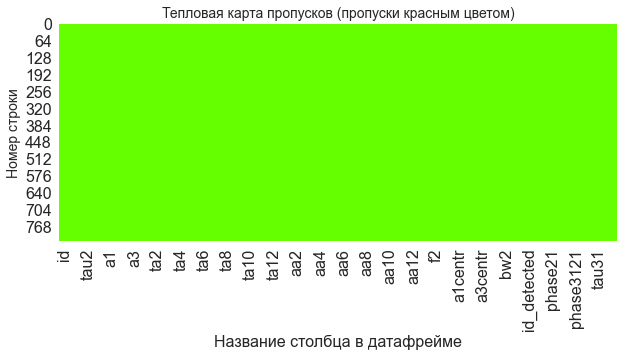

На наличие NaN значений в относительном выражении в %:
 id             0.0
tau1           0.0
tau2           0.0
tau3           0.0
a1             0.0
a2             0.0
a3             0.0
ta1            0.0
ta2            0.0
ta3            0.0
ta4            0.0
ta5            0.0
ta6            0.0
ta7            0.0
ta8            0.0
ta9            0.0
ta10           0.0
ta11           0.0
ta12           0.0
aa1            0.0
aa2            0.0
aa3            0.0
aa4            0.0
aa5            0.0
aa6            0.0
aa7            0.0
aa8            0.0
aa9            0.0
aa10           0.0
aa11           0.0
aa12           0.0
f1             0.0
f2             0.0
f3             0.0
a1centr        0.0
a2centr        0.0
a3centr        0.0
bw1            0.0
bw2            0.0
bw3            0.0
id_detected    0.0
delta_a        0.0
phase21        0.0
phase31        0.0
phase3121      0.0
tau21          0.0
tau31          0.0
tau3121        0.0
dtype: float64
На наличие пропус

,id,tau1,tau2,tau3,a1,a2,a3,ta1,ta2,ta3,ta4,ta5,ta6,ta7,ta8,ta9,ta10,ta11,ta12,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,aa11,aa12,f1,f2,f3,a1centr,a2centr,a3centr,bw1,bw2,bw3,id_detected,delta_a,phase21,phase31,phase3121,tau21,tau31,tau3121
0,1.000000,0.000001,0.000002,0.000002,31.114380,28.421020,26.656340,0.000003,0.000001,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,0.000001,0.000002,0.000003,0.000002,-44.824470,-47.880490,-49.834040,-51.447360,-51.918770,-52.082120,-53.407720,-53.634990,-54.221640,-54.658960,-58.497360,-60.606250,2480530000.000000,2455600000.000000,2454538000.000000,27.446110,25.944080,24.338670,35517700.000000,99881680.000000,100410100.000000,2.000000,6.000000,138.100000,44.300000,128.200000,673.690000,1421.450000,74.070000
1,2.000000,0.000001,0.000002,0.000002,31.077580,28.945920,27.090390,0.000003,0.000001,0.000002,0.000002,0.000003,0.000002,0.000003,0.000002,0.000001,0.000003,0.000002,0.000003,-45.338280,-48.910940,-50.322400,-51.960650,-52.217650,-53.014590,-53.796240,-53.839930,-54.074360,-56.225140,-59.840660,-60.219650,2480677000.000000,2454323000.000000,2453657000.000000,27.445270,26.436690,24.719460,35007940.000000,101161200.000000,100480100.000000,3.000000,7.000000,134.300000,26.200000,117.600000,673.560000,1422.160000,75.030000
2,3.000000,0.000001,0.000002,0.000002,31.736470,29.655900,27.819840,0.000003,0.000001,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,0.000001,0.000003,0.000002,0.000003,-45.980490,-49.744680,-51.833830,-52.736170,-53.225730,-54.229390,-54.591270,-54.733790,-55.077080,-57.261240,-61.126820,-61.372690,2479657000.000000,2455201000.000000,2454256000.000000,28.343070,27.267590,25.555300,37357520.000000,101375800.000000,101235300.000000,4.000000,5.000000,137.000000,34.900000,120.900000,673.570000,1421.380000,74.240000
3,4.000000,0.000001,0.000002,0.000003,31.844410,29.696270,28.156440,0.000003,0.000001,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,0.000003,0.000002,0.000002,0.000002,-46.650430,-51.734060,-53.196200,-53.338220,-53.785120,-55.009200,-55.028460,-56.645620,-56.967410,-60.777520,-65.769510,-67.304970,2480845000.000000,2455377000.000000,2455253000.000000,28.536490,27.452590,25.887130,39969970.000000,101862100.000000,99884570.000000,5.000000,5.000000,131.200000,28.700000,126.200000,673.290000,1421.630000,75.040000
4,5.000000,0.000001,0.000002,0.000003,32.269940,30.181390,28.483310,0.000003,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,0.000001,0.000003,0.000001,0.000003,0.000003,-46.751190,-52.781750,-53.170780,-53.880870,-54.343380,-55.620190,-56.330800,-57.533670,-57.835360,-58.523220,-61.953290,-63.421380,2476310000.000000,2455200000.000000,2454774000.000000,29.722000,27.887790,26.304190,59727960.000000,101347800.000000,100087300.000000,6.000000,5.000000,131.300000,20.400000,117.800000,673.290000,1420.820000,74.230000


In [6]:
nan_check(zond)

**Проверим на наличие дубликатов**

In [7]:
zond.duplicated().sum()

0

**Приведем значения в более читаемый вид:**

In [8]:
# переводим id метки в целочисленный тип
zond['id'] = zond['id'].astype('int64')
zond['id_detected'] = zond['id_detected'].astype('int64')

# переводим значения рабочей частоты в ГГц
zond[['f1', 'f2', 'f3']] = zond[['f1', 'f2', 'f3']] / 1E+9

# переводим значения времени отклика в нс
zond[['tau1', 'tau2', 'tau3']] = \
                        (zond[['tau1', 'tau2', 'tau3']] * 1E+9).round(1)


# переводим значения полосы пропускания bandwidth в МГц
zond[['bw1', 'bw2', 'bw3']] = zond[['bw1', 'bw2', 'bw3']] / 1E+6

# округлим значения ослабления сигнала attenuation
zond[['a1', 'a2', 'a3']] = zond[['a1', 'a2', 'a3']].round(2)

**Определим разброс значений ослабления сигнала и максиму ширины полосы пропускания:**

In [9]:
# добавим максимум и минимум по ослаблению сигнала для каждой радиометки
zond['a_max'] = zond[['a1', 'a2', 'a3']].max(axis=1)
zond['a_min'] = zond[['a1', 'a2', 'a3']].min(axis=1)

# определим неравномерность ослабления
zond['a_diff'] = zond['a_max'] - zond['a_min'] 

# добавим максимум по полосе пропускания для каждой радиометки
zond['bw_max'] = zond[['bw1', 'bw2', 'bw3']].max(axis=1)
zond['aa_min'] = zond[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 
                       'aa9', 'aa10','aa11', 'aa12']].min(axis=1).mul(-1)

zond[['bw1', 'bw2', 'bw3', 'bw_max']] = \
                            zond[['bw1', 'bw2', 'bw3', 'bw_max']].round(2)

# разместим столбцы по важности
zond = zond[['id', 'tau1', 'tau2', 'tau3', 'a1', 'a2', 'a3', 'a_max', 'a_min', 
             'a_diff', 'bw1', 'bw2', 'bw3', 'bw_max', 'ta1', 'ta2', 'ta3', 
             'ta4', 'ta5', 'ta6', 'ta7', 'ta8', 'ta9', 'ta10', 'ta11', 'ta12', 
             'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9', 
             'aa10', 'aa11', 'aa12', 'aa_min', 'f1', 'f2', 'f3', 'a1centr', 
             'a2centr', 'a3centr', 'id_detected', 'delta_a', 'phase21', 
             'phase31', 'phase3121', 'tau21', 'tau31', 'tau3121']]

display(zond.head())

,id,tau1,tau2,tau3,a1,a2,a3,a_max,a_min,a_diff,bw1,bw2,bw3,bw_max,ta1,ta2,ta3,ta4,ta5,ta6,ta7,ta8,ta9,ta10,ta11,ta12,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,aa11,aa12,aa_min,f1,f2,f3,a1centr,a2centr,a3centr,id_detected,delta_a,phase21,phase31,phase3121,tau21,tau31,tau3121
0,1,881.3,1557.3,2307.1,31.11,28.42,26.66,31.11,26.66,4.45,35.52,99.88,100.41,100.41,0.000003,8.585000e-07,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,9.035000e-07,2.438000e-06,0.000003,0.000002,-44.82447,-47.88049,-49.83404,-51.44736,-51.91877,-52.08212,-53.40772,-53.63499,-54.22164,-54.65896,-58.49736,-60.60625,60.60625,2.480530,2.455600,2.454538,27.44611,25.94408,24.33867,2,6.0,138.1,44.3,128.2,673.69,1421.45,74.07
1,2,957.0,1631.5,2381.2,31.08,28.95,27.09,31.08,27.09,3.99,35.01,101.16,100.48,101.16,0.000003,9.335000e-07,0.000002,0.000002,0.000003,0.000002,0.000003,0.000002,9.785000e-07,2.587250e-06,0.000002,0.000003,-45.33828,-48.91094,-50.32240,-51.96065,-52.21765,-53.01459,-53.79624,-53.83993,-54.07436,-56.22514,-59.84066,-60.21965,60.21965,2.480677,2.454323,2.453657,27.44527,26.43669,24.71946,3,7.0,134.3,26.2,117.6,673.56,1422.16,75.03
2,3,1031.3,1707.3,2457.1,31.74,29.66,27.82,31.74,27.82,3.92,37.36,101.38,101.24,101.38,0.000003,1.008500e-06,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,1.053500e-06,2.738000e-06,0.000002,0.000003,-45.98049,-49.74468,-51.83383,-52.73617,-53.22573,-54.22939,-54.59127,-54.73379,-55.07708,-57.26124,-61.12682,-61.37269,61.37269,2.479657,2.455201,2.454256,28.34307,27.26759,25.55530,4,5.0,137.0,34.9,120.9,673.57,1421.38,74.24
3,4,1107.2,1781.6,2531.5,31.84,29.70,28.16,31.84,28.16,3.68,39.97,101.86,99.88,101.86,0.000003,1.083500e-06,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,2.888750e-06,2.456000e-06,0.000002,0.000002,-46.65043,-51.73406,-53.19620,-53.33822,-53.78512,-55.00920,-55.02846,-56.64562,-56.96741,-60.77752,-65.76951,-67.30497,67.30497,2.480845,2.455377,2.455253,28.53649,27.45259,25.88713,5,5.0,131.2,28.7,126.2,673.29,1421.63,75.04
4,5,1181.5,1857.2,2606.9,32.27,30.18,28.48,32.27,28.48,3.79,59.73,101.35,100.09,101.35,0.000003,2.628500e-06,0.000003,0.000003,0.000002,0.000002,0.000001,0.000001,3.037250e-06,5.007500e-07,0.000003,0.000003,-46.75119,-52.78175,-53.17078,-53.88087,-54.34338,-55.62019,-56.33080,-57.53367,-57.83536,-58.52322,-61.95329,-63.42138,63.42138,2.476310,2.455200,2.454774,29.72200,27.88779,26.30419,6,5.0,131.3,20.4,117.8,673.29,1420.82,74.23


Таким образом, видим, что в файле с функциональными характеристиками все 825 меток на пластине работоспособны - нет пропущенных значений, а также дубликатов. Значения частоты, времени отклика и ширины полосы пропускания приведены к более удобночитаемым единицами измерения. К исходному набору данных добавлены такие необходимые расчетные параметры как: 
- неравномерность затухания;
- максимум полосы пропускания.

### 3.2 Данные с технологическими характеристиками при экспонировании каждой радиометки на степпере <a id="stepper">
  - `X` — смещение стола-держателя пластины по координате X;
  - `Y` — смещение стола-держателя пластины по координате Y;
  - `Z1`, `Z2`, `Z3` — параметры корректировки плоскости фокусировки (координата Z);
  - `temp0`, `temp1`,  `temp2`, `temp3` — температура в плоскости основания, держателя фотошаблона, объектива, стола-держателя в $^\circ C$;
  - `pressure` — давление в помещении в мм.рт.ст;

In [10]:
# пропускаем первые три строки, чтобы потом было удобно взять каждую четвертую
step = pd.read_csv('stepper_base.txt', sep='|', header=None, skiprows=3)
step = step.drop([0, 13], axis=1)  

# переименуем по-человечески
step.columns=['module', 'id', 'X', 'Y', 'Z1', 'Z2', 'Z3', 'temp0', 'pressure', 
              'temp1', 'temp2', 'temp3', ]

# берем каждую четвертую строку
step = step[np.mod(np.arange(step.index.size), 4) == 0].reset_index(drop=True)

# изменим знак для X и Y координат
step['X'] = step['X'].mul(-1)
step['Y'] = step['Y'].mul(-1)

# уберем дублирующий номер модуля
step = step.drop('module', axis=1)

display(step.head())

,id,X,Y,Z1,Z2,Z3,temp0,pressure,temp1,temp2,temp3
0,1,18400.0,39480.0,-34.80,-32.99,-106.91,20.58,749.0,21.26,20.82,20.85
1,2,17250.0,39480.0,-34.69,-32.89,-106.81,20.57,749.0,21.33,20.82,20.85
2,3,16100.0,39480.0,-34.72,-32.91,-106.83,20.57,749.0,21.31,20.82,20.85
3,4,14950.0,39480.0,-34.80,-32.99,-106.91,20.57,749.0,21.26,20.82,20.85
4,5,13800.0,39480.0,-34.93,-33.12,-107.04,20.57,749.0,21.31,20.82,20.85


**Проверим на наличие пропусков**

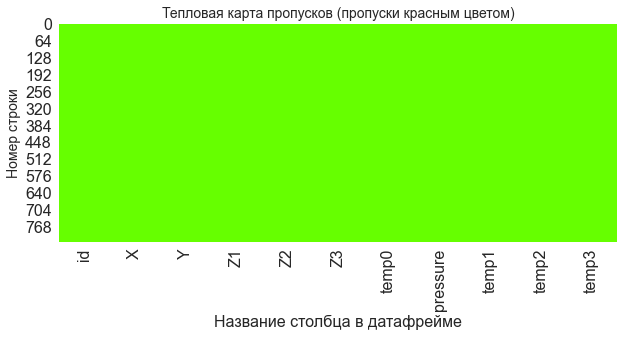

На наличие NaN значений в относительном выражении в %:
 id          0.0
X           0.0
Y           0.0
Z1          0.0
Z2          0.0
Z3          0.0
temp0       0.0
pressure    0.0
temp1       0.0
temp2       0.0
temp3       0.0
dtype: float64
На наличие пропусков как строковых значений в шт.:
 id          0
X           0
Y           0
Z1          0
Z2          0
Z3          0
temp0       0
pressure    0
temp1       0
temp2       0
temp3       0
dtype: int64


,id,X,Y,Z1,Z2,Z3,temp0,pressure,temp1,temp2,temp3
0,1,18400.000000,39480.000000,-34.800000,-32.990000,-106.910000,20.580000,749.000000,21.260000,20.820000,20.850000
1,2,17250.000000,39480.000000,-34.690000,-32.890000,-106.810000,20.570000,749.000000,21.330000,20.820000,20.850000
2,3,16100.000000,39480.000000,-34.720000,-32.910000,-106.830000,20.570000,749.000000,21.310000,20.820000,20.850000
3,4,14950.000000,39480.000000,-34.800000,-32.990000,-106.910000,20.570000,749.000000,21.260000,20.820000,20.850000
4,5,13800.000000,39480.000000,-34.930000,-33.120000,-107.040000,20.570000,749.000000,21.310000,20.820000,20.850000


In [11]:
nan_check(step)

Таким образом, в данном разделе считаны данные о том, какие параметры были при изготовлении. Видим, что пропусков нет, по каждой радиометке данные получены. Теперь объединяя датасеты получаем рабочий датасет, в котором известны координаты радиометки на пластине, параметры при её изготовлении и её итоговые функциональные характеристики.

### 3.3. Объединение датасетов с фунциональными и технологическим характеристиками <a id="merge">
Проводим его по id радиометки:

In [12]:
marks = step.merge(zond, on='id')
marks.head()

,id,X,Y,Z1,Z2,Z3,temp0,pressure,temp1,temp2,temp3,tau1,tau2,tau3,a1,a2,a3,a_max,a_min,a_diff,bw1,bw2,bw3,bw_max,ta1,ta2,ta3,ta4,ta5,ta6,ta7,ta8,ta9,ta10,ta11,ta12,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,aa11,aa12,aa_min,f1,f2,f3,a1centr,a2centr,a3centr,id_detected,delta_a,phase21,phase31,phase3121,tau21,tau31,tau3121
0,1,18400.0,39480.0,-34.80,-32.99,-106.91,20.58,749.0,21.26,20.82,20.85,881.3,1557.3,2307.1,31.11,28.42,26.66,31.11,26.66,4.45,35.52,99.88,100.41,100.41,0.000003,8.585000e-07,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,9.035000e-07,2.438000e-06,0.000003,0.000002,-44.82447,-47.88049,-49.83404,-51.44736,-51.91877,-52.08212,-53.40772,-53.63499,-54.22164,-54.65896,-58.49736,-60.60625,60.60625,2.480530,2.455600,2.454538,27.44611,25.94408,24.33867,2,6.0,138.1,44.3,128.2,673.69,1421.45,74.07
1,2,17250.0,39480.0,-34.69,-32.89,-106.81,20.57,749.0,21.33,20.82,20.85,957.0,1631.5,2381.2,31.08,28.95,27.09,31.08,27.09,3.99,35.01,101.16,100.48,101.16,0.000003,9.335000e-07,0.000002,0.000002,0.000003,0.000002,0.000003,0.000002,9.785000e-07,2.587250e-06,0.000002,0.000003,-45.33828,-48.91094,-50.32240,-51.96065,-52.21765,-53.01459,-53.79624,-53.83993,-54.07436,-56.22514,-59.84066,-60.21965,60.21965,2.480677,2.454323,2.453657,27.44527,26.43669,24.71946,3,7.0,134.3,26.2,117.6,673.56,1422.16,75.03
2,3,16100.0,39480.0,-34.72,-32.91,-106.83,20.57,749.0,21.31,20.82,20.85,1031.3,1707.3,2457.1,31.74,29.66,27.82,31.74,27.82,3.92,37.36,101.38,101.24,101.38,0.000003,1.008500e-06,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,1.053500e-06,2.738000e-06,0.000002,0.000003,-45.98049,-49.74468,-51.83383,-52.73617,-53.22573,-54.22939,-54.59127,-54.73379,-55.07708,-57.26124,-61.12682,-61.37269,61.37269,2.479657,2.455201,2.454256,28.34307,27.26759,25.55530,4,5.0,137.0,34.9,120.9,673.57,1421.38,74.24
3,4,14950.0,39480.0,-34.80,-32.99,-106.91,20.57,749.0,21.26,20.82,20.85,1107.2,1781.6,2531.5,31.84,29.70,28.16,31.84,28.16,3.68,39.97,101.86,99.88,101.86,0.000003,1.083500e-06,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,2.888750e-06,2.456000e-06,0.000002,0.000002,-46.65043,-51.73406,-53.19620,-53.33822,-53.78512,-55.00920,-55.02846,-56.64562,-56.96741,-60.77752,-65.76951,-67.30497,67.30497,2.480845,2.455377,2.455253,28.53649,27.45259,25.88713,5,5.0,131.2,28.7,126.2,673.29,1421.63,75.04
4,5,13800.0,39480.0,-34.93,-33.12,-107.04,20.57,749.0,21.31,20.82,20.85,1181.5,1857.2,2606.9,32.27,30.18,28.48,32.27,28.48,3.79,59.73,101.35,100.09,101.35,0.000003,2.628500e-06,0.000003,0.000003,0.000002,0.000002,0.000001,0.000001,3.037250e-06,5.007500e-07,0.000003,0.000003,-46.75119,-52.78175,-53.17078,-53.88087,-54.34338,-55.62019,-56.33080,-57.53367,-57.83536,-58.52322,-61.95329,-63.42138,63.42138,2.476310,2.455200,2.454774,29.72200,27.88779,26.30419,6,5.0,131.3,20.4,117.8,673.29,1420.82,74.23


**Посчитаем процент работоспособных меток**

In [13]:
alive_ratio = marks[marks['id_detected'] != 0].shape[0] / marks.shape[0]
md('**Процент работоспособных меток: {:.2%}**'.format(alive_ratio))

**Процент работоспособных меток: 85.82%**

Таким образом, из всех радиометок на пластине отклик дают ~86% меток. Далее рассчитываем процент радиометок удовлетворяющих требованиям ТЗ, которые [описаны выше](#requirements).

## 4. Разметка данных и построение карты годных радиометок <a id="yield_ratio">
[к содержанию](#contents)

### 4.1 Разметка данных (годные "1", бракованные "0") <a id="classes">
Сначала оставим в датафрейме столбцы необходимые для разметки, выходного pdf-отчета и построения карты годных.

In [14]:
marks = marks[['id', 'X', 'Y',  'Z1', 'Z2', 'Z3', 'pressure', 'temp0', 'temp1', 
         'temp2', 'temp3', 'a1', 'a2', 'a3',  'delta_a', 'bw1', 'bw2', 'bw3', 
         'phase3121', 'phase21', 'phase31', 'a_max', 'bw_max', 'a_diff', 
         'aa_min', 'f1', 'f2', 'f3']]

marks.head()

,id,X,Y,Z1,Z2,Z3,pressure,temp0,temp1,temp2,temp3,a1,a2,a3,delta_a,bw1,bw2,bw3,phase3121,phase21,phase31,a_max,bw_max,a_diff,aa_min,f1,f2,f3
0,1,18400.0,39480.0,-34.80,-32.99,-106.91,749.0,20.58,21.26,20.82,20.85,31.11,28.42,26.66,6.0,35.52,99.88,100.41,128.2,138.1,44.3,31.11,100.41,4.45,60.60625,2.480530,2.455600,2.454538
1,2,17250.0,39480.0,-34.69,-32.89,-106.81,749.0,20.57,21.33,20.82,20.85,31.08,28.95,27.09,7.0,35.01,101.16,100.48,117.6,134.3,26.2,31.08,101.16,3.99,60.21965,2.480677,2.454323,2.453657
2,3,16100.0,39480.0,-34.72,-32.91,-106.83,749.0,20.57,21.31,20.82,20.85,31.74,29.66,27.82,5.0,37.36,101.38,101.24,120.9,137.0,34.9,31.74,101.38,3.92,61.37269,2.479657,2.455201,2.454256
3,4,14950.0,39480.0,-34.80,-32.99,-106.91,749.0,20.57,21.26,20.82,20.85,31.84,29.70,28.16,5.0,39.97,101.86,99.88,126.2,131.2,28.7,31.84,101.86,3.68,67.30497,2.480845,2.455377,2.455253
4,5,13800.0,39480.0,-34.93,-33.12,-107.04,749.0,20.57,21.31,20.82,20.85,32.27,30.18,28.48,5.0,59.73,101.35,100.09,117.8,131.3,20.4,32.27,101.35,3.79,63.42138,2.476310,2.455200,2.454774


Напишем функцию для проверки соответствия требованиям критериев-годности:

In [15]:
def chip_labeling(row):
    '''Функция расставляет флаги над метками полностью удовлетворяющим
    требованиям ТЗ в части функциональных характеристик. 
    Годные - класс "1", бракованные - класс "0" '''
    try:
        if row['a_max'] <= A_LIMIT and \
        row['bw_max'] >= BW_LIMIT and \
        row['a_diff'] <= A_ROUGHNESS and \
        (row['aa_min'] - row['a_max']) >= A_SPREAD and \
        row['f1'] >= F1_MIN and \
        row['f1'] <= F1_MAX and \
        row['f2'] >= F2_MIN and \
        row['f2'] <= F2_MAX and \
        row['f3'] >= F3_MIN and \
        row['f3'] <= F3_MAX:
            return 1
        else:
            return 0
    except:
        print('Необработаны данные по радиометке:', row['id'])

Применим функцию к датафрейму, посчитаем количество годных меток коэффициент выхода годных:

In [16]:
marks['is_good']  = marks.apply(chip_labeling, axis=1)
marks.head(10)

,id,X,Y,Z1,Z2,Z3,pressure,temp0,temp1,temp2,temp3,a1,a2,a3,delta_a,bw1,bw2,bw3,phase3121,phase21,phase31,a_max,bw_max,a_diff,aa_min,f1,f2,f3,is_good
0,1,18400.0,39480.0,-34.80,-32.99,-106.91,749.0,20.58,21.26,20.82,20.85,31.11,28.42,26.66,6.0,35.52,99.88,100.41,128.2,138.1,44.3,31.11,100.41,4.45,60.60625,2.480530,2.455600,2.454538,0
1,2,17250.0,39480.0,-34.69,-32.89,-106.81,749.0,20.57,21.33,20.82,20.85,31.08,28.95,27.09,7.0,35.01,101.16,100.48,117.6,134.3,26.2,31.08,101.16,3.99,60.21965,2.480677,2.454323,2.453657,0
2,3,16100.0,39480.0,-34.72,-32.91,-106.83,749.0,20.57,21.31,20.82,20.85,31.74,29.66,27.82,5.0,37.36,101.38,101.24,120.9,137.0,34.9,31.74,101.38,3.92,61.37269,2.479657,2.455201,2.454256,0
3,4,14950.0,39480.0,-34.80,-32.99,-106.91,749.0,20.57,21.26,20.82,20.85,31.84,29.70,28.16,5.0,39.97,101.86,99.88,126.2,131.2,28.7,31.84,101.86,3.68,67.30497,2.480845,2.455377,2.455253,0
4,5,13800.0,39480.0,-34.93,-33.12,-107.04,749.0,20.57,21.31,20.82,20.85,32.27,30.18,28.48,5.0,59.73,101.35,100.09,117.8,131.3,20.4,32.27,101.35,3.79,63.42138,2.476310,2.455200,2.454774,0
5,6,12650.0,39480.0,-35.01,-33.20,-107.12,749.0,20.57,21.28,20.82,20.85,32.92,30.98,29.33,4.0,60.58,99.92,100.36,117.4,133.4,24.3,32.92,100.36,3.59,62.32163,2.476186,2.455789,2.454814,0
6,7,11500.0,39480.0,-35.08,-33.28,-107.20,749.0,20.57,21.32,20.82,20.85,33.13,31.17,29.48,5.0,98.12,101.18,101.20,119.7,132.4,24.5,33.13,101.20,3.65,62.59402,2.458155,2.456945,2.455597,1
7,8,10350.0,39480.0,-35.22,-33.41,-107.36,749.0,20.57,21.28,20.82,20.85,33.77,31.51,29.93,5.0,64.11,98.50,98.76,122.1,130.0,22.1,33.77,98.76,3.84,62.60230,2.476074,2.458504,2.456745,0
8,9,9200.0,39480.0,-35.16,-33.36,-107.30,749.0,20.57,21.25,20.82,20.85,30.24,28.44,26.68,6.0,35.37,98.55,98.26,142.4,101.0,344.3,30.24,98.55,3.56,58.04964,2.480959,2.459921,2.458838,0
9,10,8050.0,39480.0,-35.35,-33.54,-107.49,749.0,20.57,21.34,20.82,20.85,30.82,28.87,27.23,5.0,35.99,99.18,98.23,126.5,106.7,339.9,30.82,99.18,3.59,59.93049,2.484720,2.459749,2.458456,0


Сохраним годные и бракованные метки в датафреймы для последующего анализа

In [17]:
good_marks = marks[marks['is_good'] == 1]
bad_marks = marks[marks['is_good'] == 0]

number_bad = bad_marks.shape[0]
number_good = good_marks.shape[0]
md('**Количество годных меток - {} шт., бракованных - {} шт.**'.format(number_good, 
                                                              number_bad))

**Количество годных меток - 180 шт., бракованных - 645 шт.**

In [18]:
yield_ratio = number_good / (number_good + number_bad)

md('**Коэффициент выхода годных: {:.2%}**'.format(yield_ratio))

**Коэффициент выхода годных: 21.82%**

Таким образом, из общего количества в 825 радиометок, работоспособны 86% (709 радиометок), но только 22% (180 радиометок) удовлетворяют требования ТЗ. Анализ того, какие именно параметры не удволетворяют требованиям делаем ниже.

### 4.2 Карта годных <a id="yield_map">

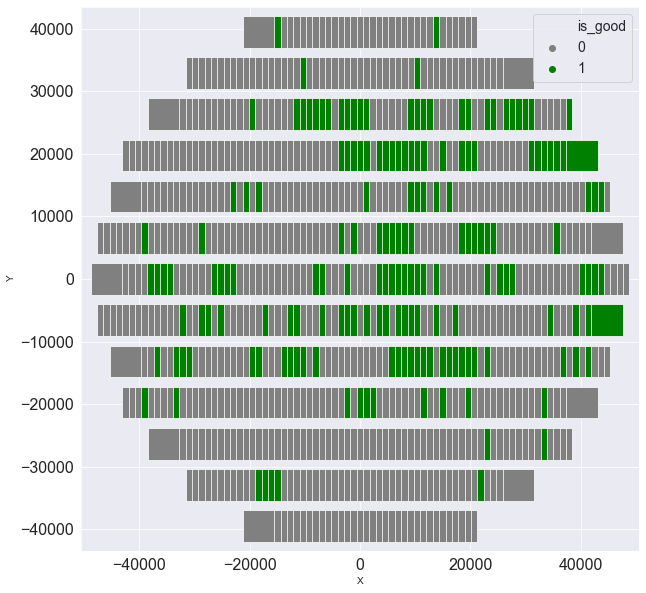

In [36]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(data=marks, x='X', y='Y', hue='is_good', marker='s', s=1000, 
                palette=['grey', 'green'])
plt.legend(fontsize=14)
plt.savefig('yield_map', transparent=False, quality=95)
plt.show()

Данная карта годных уже является продуктом. Она передавалась на участок сборки, чтобы коллеги знали какие именно радиометки снимать с пластины для последующего корпусирования.

На данной карте годных нет визуально заметной закономерности расположения годных меток, но зачастую по расположению годных можно было определить участок производтвенной линейки где произошло отклонение технологии от нормы.

# 5. Анализ распределений ключевых характеристик <a id="EDA">
[к содержанию](#contents)
    
Данные распределения строятся для того, чтобы понять по каким именно параметрам отбраковываем радиометки, какие характеристики не укладываются в требования ТЗ.

### 5.1 Распределения характеристик <a id="distributions">

In [20]:
def quick_2hist(data, col1, col1_unit, col1_limit, 
                      col2, col2_unit, col2_limit):
    '''Строит распределение указанных признаков и допустимые границы
    их значений по ТЗ'''
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(wspace = 0.3)
    
    # Гистограмма первого признака
    plt.subplot(221)
    sns.distplot(data[col1], bins=50, kde=False, color='green')
    plt.grid(True)
    plt.xlabel("Признак {} ({})".format(col1, col1_unit), fontsize=14)
    plt.axvline(col1_limit, color='blue', linestyle='--')
    # Гистограмма второго признака
    plt.subplot(222)
    sns.distplot(data[col2], bins=50, kde=False, color='green')
    plt.grid(True)
    plt.xlabel("Признак {} ({})".format(col2, col2_unit), fontsize=14)
    plt.axvline(col2_limit, color='red', linestyle='--')

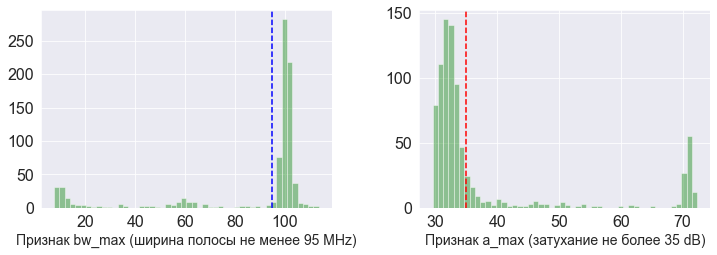

In [21]:
quick_2hist(marks, 'bw_max', 'ширина полосы не менее {} MHz'.format(BW_LIMIT), BW_LIMIT,
                   'a_max', 'затухание не более {} dB'.format(A_LIMIT), A_LIMIT)

Здесь и далее <font color=blue> синей штриховой </font> обозначена нижняя граница признака, <font color=red> красной штриховой </font>  - верхняя граница.

Видно, что у небольшой части радиометок завышены значения затухания сигнала. Скорее всего, это обусловлено дефектами структуры и/или загрязнениями попавшими на поверхность радиометок.

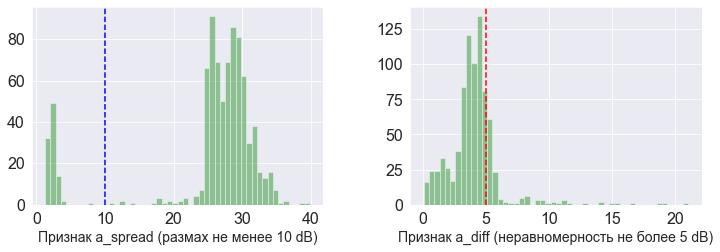

In [22]:
marks['a_spread'] = marks['aa_min'] - marks['a_max']
quick_2hist(marks, 'a_spread', 'размах не менее {} dB'.format(A_SPREAD), A_SPREAD,
                   'a_diff', 'неравномерность не более {} dB'.format(A_ROUGHNESS), A_ROUGHNESS)

По размаху и неравномерности затухания в целом картина в норме, только небольшая часть меток отбракована по данному параметру.

In [23]:
def quick_freq(data, col1, col2, col3, bins,
               f_low, f_high):
    '''Строит распределения частот и их допустимых границ по ТЗ'''
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace = 0.3)
    
    # Гистограмма частоты f1
    plt.subplot(231)
    sns.distplot(data.query('f1 != 0')[col1], bins=bins, kde=False, color='green')
    plt.grid(True)
    plt.xlabel("Распределение частоты f1 (в ГГц)", fontsize=14)
    plt.axvline(F1_MIN, color='blue', linestyle='--')
    plt.axvline(F1_MAX, color='red', linestyle='--')
    plt.xlim(f_low, f_high)
    # Гистограмма частоты f2
    plt.subplot(232)
    sns.distplot(data.query('f2 != 0')[col2], bins=bins, kde=False, color='green')
    plt.grid(True)
    plt.xlabel("Распределение частоты f2 (в ГГц)", fontsize=14)
    plt.axvline(F2_MIN, color='blue', linestyle='--')
    plt.axvline(F2_MAX, color='red', linestyle='--')
    plt.xlim(f_low, f_high)
    # Гистограмма частоты f3
    plt.subplot(233)
    sns.distplot(data.query('f3 != 0')[col3], bins=bins, kde=False, color='green')
    plt.grid(True)
    plt.xlabel("Распределение частоты f3 (в ГГц)", fontsize=14)
    plt.axvline(F3_MIN, color='blue', linestyle='--')
    plt.axvline(F3_MAX, color='red', linestyle='--')
    plt.xlim(f_low, f_high)
    #plt.savefig('freq_total', transparent=False, quality=95)
    plt.show()

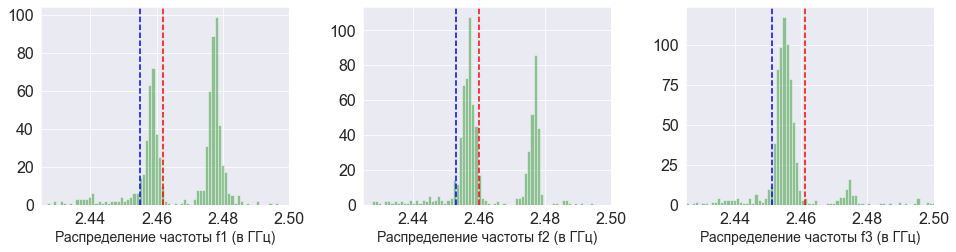

In [24]:
quick_freq(marks, col1='f1', col2='f2', col3='f3', 
           bins=200, f_low=2.425, f_high=2.500)

Из данных гистограмм хорошо видно, что большая часть меток **отбраковывается по рабочей частоте**. Особенно много радиометок заступающих за красную черту, т.е. работающие на повышенной частоте. Наиболее вероятно, это связно с тем, чт о не выдержана толщина металлизации (около 200 нм) и это повод провести дополнительную калибровку установки металлизации.

Если посмотреть на распределение частоты только для среза годных меток `good_marks`, и без Шапиро-Вилка видно, что распределения очень похожи на нормальные:

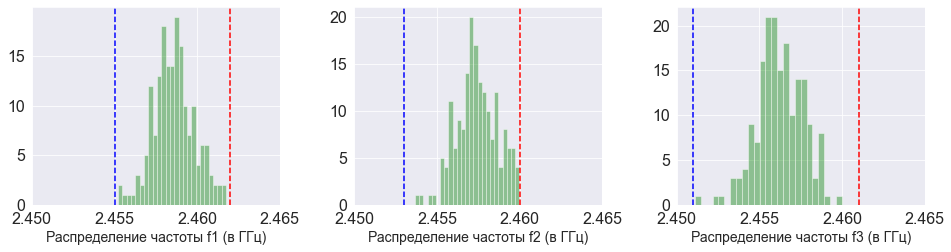

In [25]:
quick_freq(good_marks, col1='f1', col2='f2', col3='f3', 
           bins=25, f_low=2.450, f_high=2.465)

### 5.2 Сводная таблица характеристик (годные VS бракованные) <a id="pivot_table">

In [26]:
# исключаем незвучащие для бОльшей достоверности
(marks.query('f1 != 0 & f2 != 0 & f3 != 0')
     .pivot_table(
        index='is_good',
        values=['a_max', 'bw_max', 'a_diff', 'aa_min', 'f1', 'f2', 'f3'],
        aggfunc='mean')
     .round(3)
     .style
     .format('{:.3f}')
     .set_caption('Средние параметры годных и бракованных радиометок')
     .set_table_styles([{'selector': 'caption', 
                        'props': [('color', 'blue'), ('font-size', '15px')]}
                      ])
)

,a_diff,a_max,aa_min,bw_max,f1,f2,f3
is_good,,,,,,,
0,4.274,37.429,62.781,86.368,2.468,2.463,2.454
1,3.669,32.304,61.017,100.051,2.459,2.457,2.456


Из сводной таблицы видно в чем в среденем плохи бракованные метки (для быстрого перехода еще раз ссылка на коридор [допустимых значений](#requirements)), а именно:
- для них характерно повышенное затухание a_max (более 35 dB);
- недостаточная ширина полосы пропускания bw_max (менее 95 MHz);
- повышенная частота f1-f3.

### 5.3 Тепловая карта корреляций технологических и функциональных параметров <a id="heat_map">
Здесь интересует влияние значений [корректировки плоскости фокуса](#stepper) пластины на степпере `Z1` и температуры плоскости основания (область где лежит пластина во время экспонирования) на работоспособность радиометок. При этом:

- На признаки `id`, `X`, `Y` не смотрим, т.к. это просто номер метки и её координаты.
- Давление определяется обратной связью с температурой в помещении (+0.61), при повышении температуры приточно-вытяжная вентиляция создает повышенное давление. Поэтому давление не рассматриваем.
- Показатели температуры `temp0`, `temp1`, `temp2`, `temp3` сильно скоррелированы +0.98, т.к. это одно произвоздственное помещение, оставим в матрице только `temp0`.

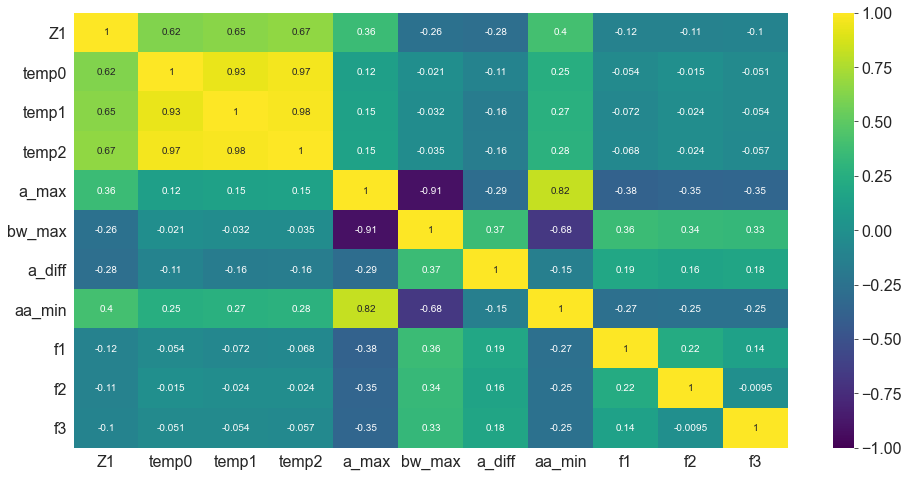

In [27]:
corr_matrix = marks[['Z1', 'temp0', 'temp1', 'temp2', 'a_max', 'bw_max', 
                     'a_diff', 'aa_min', 'f1', 'f2', 'f3',]].corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, cmap='viridis', vmin=-1, vmax=1,  annot=True)
plt.show()

Посмотрим на взаимозависимость параметров через парные графики с выделением годных и бракованных радиометок.

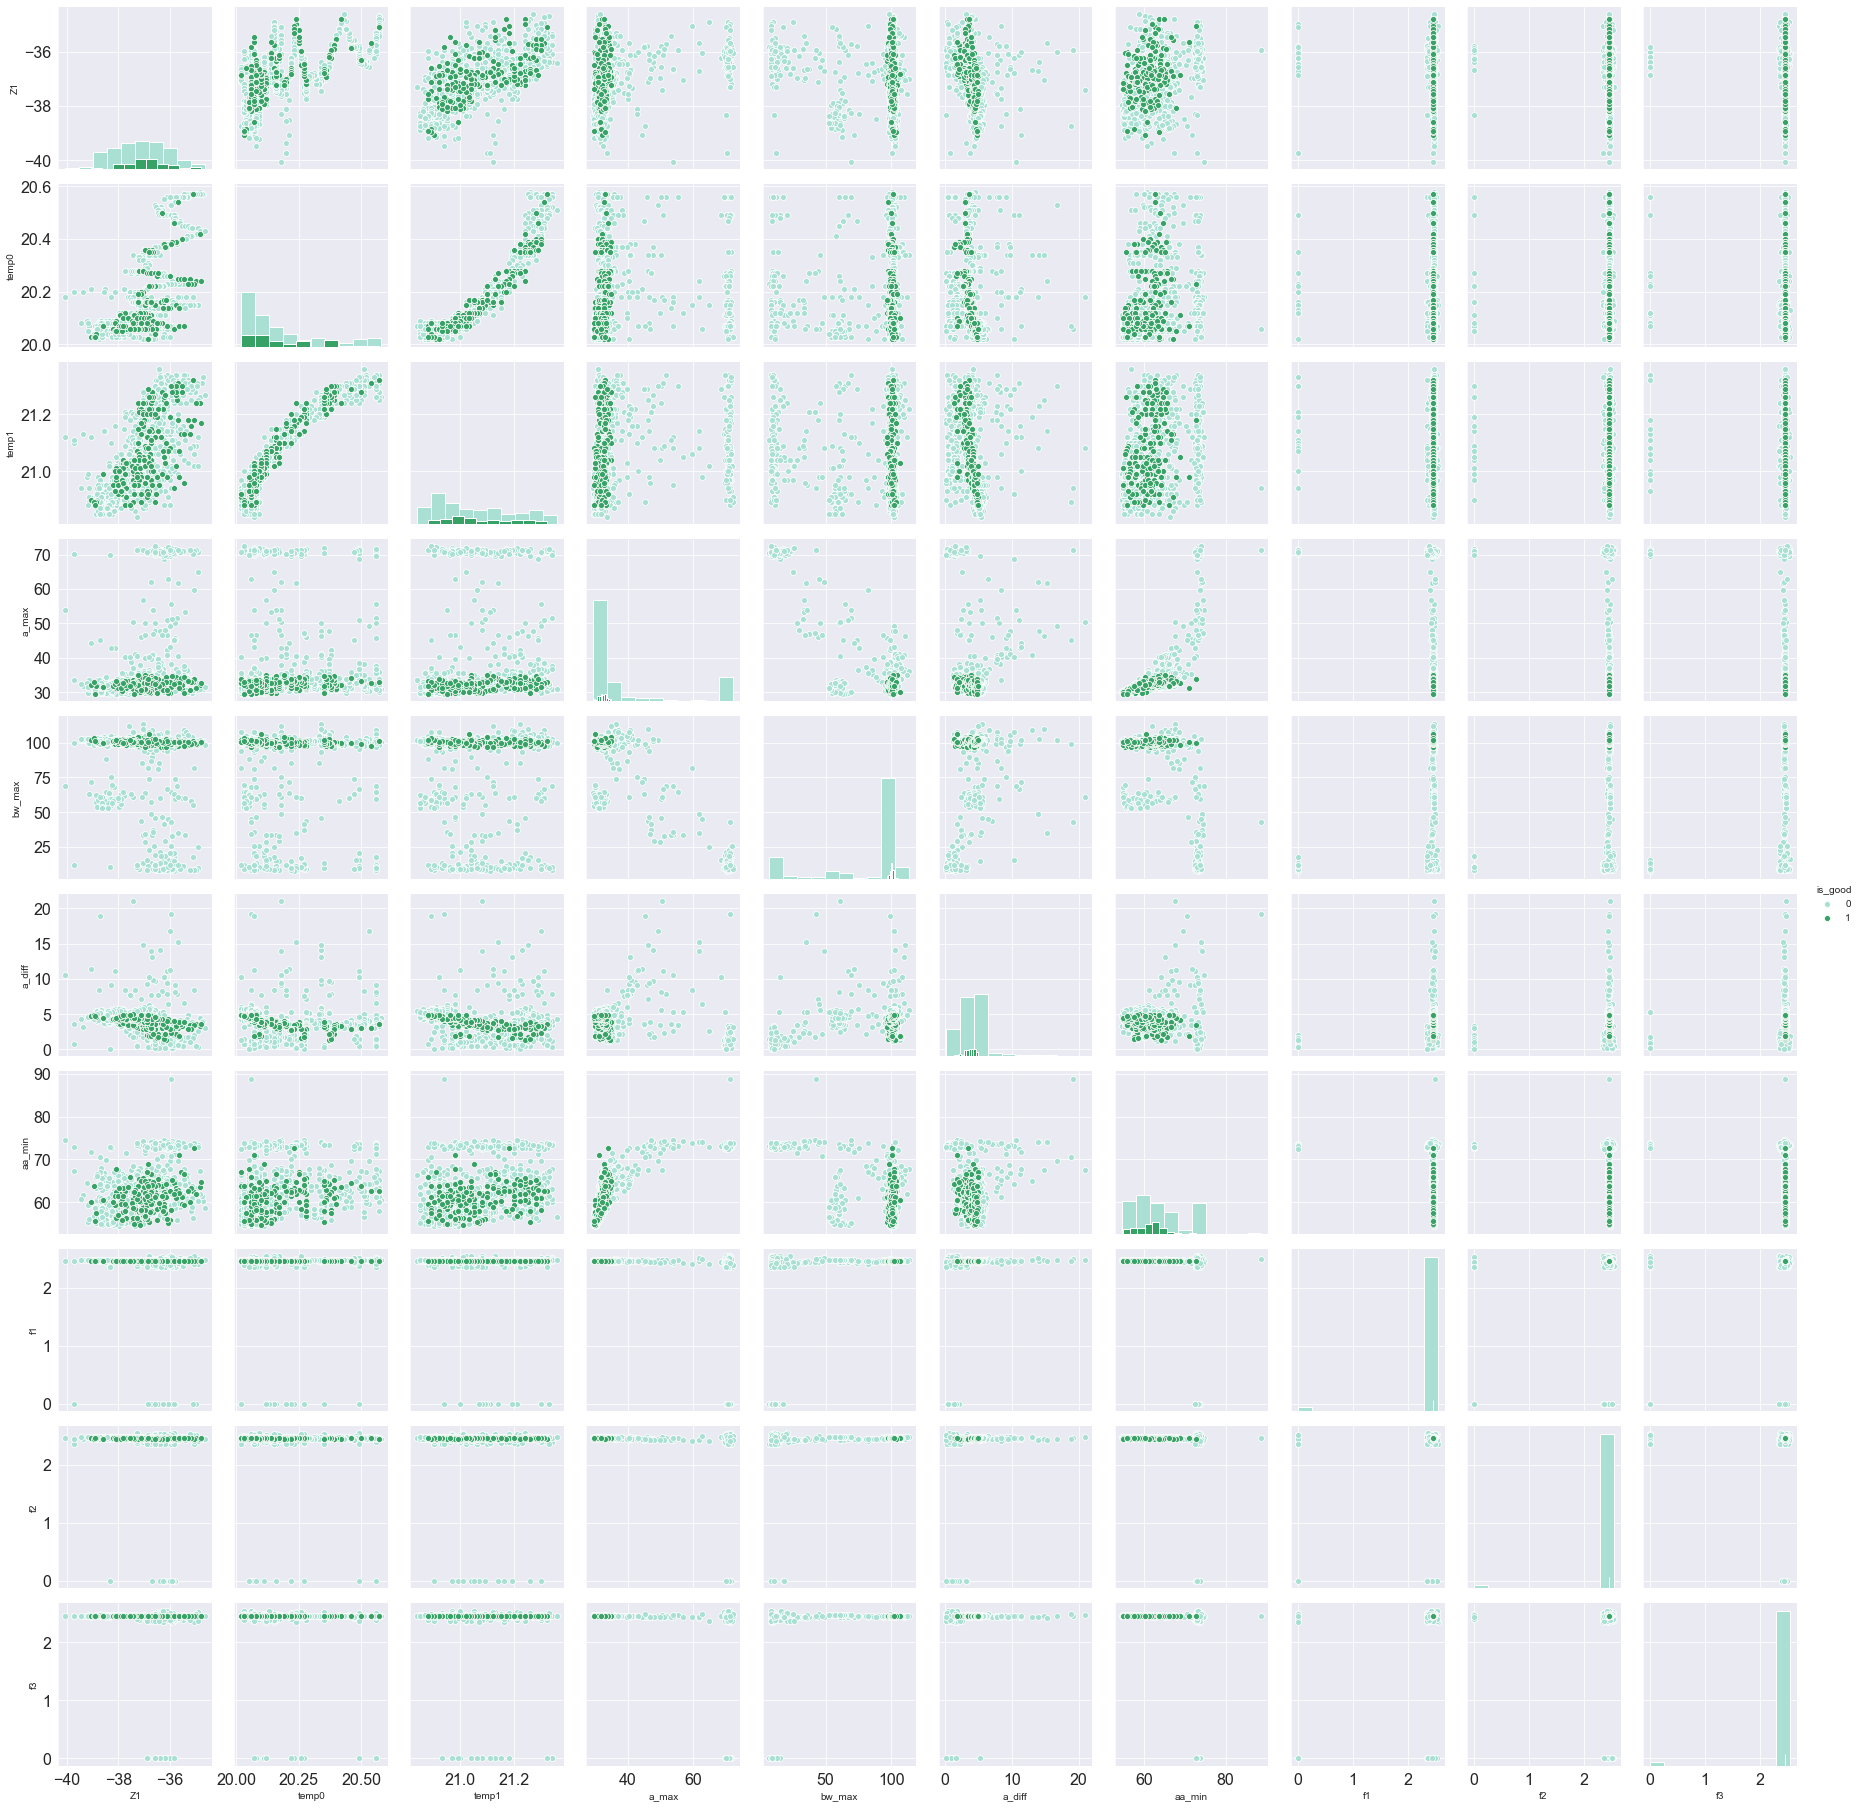

In [28]:
pairgrid = sns.pairplot(marks[['Z1', 'temp0', 'temp1', 'a_max', 'bw_max', 'a_diff',
                    'aa_min', 'f1', 'f2', 'f3', 'is_good']], diag_kind='hist',
                    hue='is_good', palette='BuGn')

plt.show()

Из графиков выше видно, что:
- есть нелинейная зависимость между плоскостью фокуса и температурой держателя пластины. Хотя здесь должна быть почти линейная зависимость, т.к. при повышении температуры и соответствующем расширении материалов плосткость фокуса уходит только в большую сторону. Соответственно, ожидается её компенсация по Z1 только в отрицательном направлении. Это вопрос для обсуждения с изготовителем степпера;
- бОльшая часть годных меток локализована при значениях плоскости фокуса от -35 до -38, уход ниже этих значений приводит к увеличению затухания;
- при этом по значениям рабочих частот "годность" меток почти не зависит от плоскости фокуса и температуры.

# 6. Статистическа проверка гипотез <a id="etching"> 
[к содержанию](#contents)
    
Как было показано выше бОльшая часть радиометок отбраковывается по частоте. В связи с чем в технологический маршрут была введена дополнительная операция ионного-плазменного травления для корректировки (adjusting) частоты отбракованных меток. Целесообразность данной дополнительной операции проводилась путем проведения парного Т-теста для зависимых выборк - радиометки с одной и той же пластины до и после травления.
    
**Нулевая гипотеза $H_0$** состоит в том, что средняя частота отбракованных радиометок до травления равна средней частоте после травления. **Альтернативная $H_1$** - что они не равны и есть статистически значимое различие.

В качестве примера возьмем значения частот для пластины (wafer) ДО травления:

In [29]:
wafer_before = pd.read_csv('zond_report_before_etching.txt', sep='\t', 
                           header = None, usecols=[31, 32, 33])
wafer_before.columns=['f1', 'f2', 'f3']

# переводим значения рабочей частоты в ГГц
wafer_before[['f1', 'f2', 'f3']] = wafer_before[['f1', 'f2', 'f3']] / 1E+9
wafer_before.head()

,f1,f2,f3
0,2.484496,2.483824,2.482476
1,2.403351,2.410547,2.395159
2,2.459107,2.427814,2.427405
3,2.484804,2.483812,2.481615
4,2.484727,2.483023,2.484258


Аналогичные значения частот для пластины ПОСЛЕ травления:

In [30]:
wafer_after = pd.read_csv('zond_report_after_etching.txt', sep='\t', 
                           header = None, usecols=[31, 32, 33])
wafer_after.columns=['f1', 'f2', 'f3']

# переводим значения рабочей частоты в ГГц
wafer_after[['f1', 'f2', 'f3']] = wafer_after[['f1', 'f2', 'f3']] / 1E+9
wafer_after.head()

,f1,f2,f3
0,2.493635,2.493250,2.491571
1,2.484694,2.483926,2.481904
2,2.484059,2.483138,2.481819
3,2.484640,2.483787,2.482295
4,2.484826,2.483707,2.483285


Продим Т-тест для зависимых выборок:

In [31]:
alpha = 0.05 
for freq in ['f1', 'f2', 'f3']:
    result = st.ttest_rel(wafer_before[freq], 
                          wafer_after[freq])
    print('p-значение: {:.4f}'.format(result.pvalue))
    if result.pvalue < alpha:
        print('для частоты {} есть статистически значимое различие'.format(freq))
    else:
        print('частота {} в среднем не поменялась'.format(freq))
    print('------------------')

p-значение: 0.0264
для частоты f1 есть статистически значимое различие
------------------
p-значение: 0.4665
частота f2 в среднем не поменялась
------------------
p-значение: 0.5253
частота f3 в среднем не поменялась
------------------


Таким образом, в данном примере значимо изменилась только частота f1. Далее экспериментальным путем подбираем режим травления, дающий необходимое по направлению и величине смещение.

# 7. Выгрузка сводного pdf-отчета (latex) <a id="report"> 
[к содержанию](#contents)

Путь по созданию отчета состол в том, что сначала генерируется шаблон в формате Latex (.tex), в него передаются необходимые графики и табличные данные, затем он конвертируется в pdf-формат.

Сначала сохраним характеристики интересующих годных меток из датасета в строку, с форматированием в виде Latex таблицы:

In [32]:
good_marks_latex = (good_marks[['id', 'a1', 'a2', 'a3', 
                               'delta_a', 'f1', 'f2', 'f3']]
                    .to_latex(index=False,
                              header=['ID метки',
                                      'A1, dB', 'A2, dB', 'A3, dB', 
                                      'delta_a, dB', 
                                    'f1, GHz', 'f2, GHz', 'f3, GHz'],
                             caption='Характеристики годных меток',
                             longtable=True)
                   )

In [33]:
marks_pivot = (marks.query('f1 != 0 & f2 != 0 & f3 != 0')
                     .pivot_table(
                        index='is_good',
                        values=['a_max', 'bw_max', 'a_diff', 'aa_min', 'f1', 'f2', 'f3'],
                        aggfunc='mean')
                     .reset_index()
                     .round(3)
                )
marks_pivot

,is_good,a_diff,a_max,aa_min,bw_max,f1,f2,f3
0,0,4.274,37.429,62.781,86.368,2.468,2.463,2.454
1,1,3.669,32.304,61.017,100.051,2.459,2.457,2.456


In [64]:
marks_pivot_latex = (marks_pivot.to_latex(index=False,
                              header=['is_good',
                                      'a_diff, dB', 'a_max, dB', 'aa_min, dB', 
                                      'bw_max, dB', 
                                    'f1, GHz', 'f2, GHz', 'f3, GHz'],
                             caption='Годные VS бракованные',
                             longtable=True)
                   )

In [79]:
# создаем файл будущего отчета в Latex 
f = open('report.tex', 'w')
# загружаем необходимые пакеты
f.write(r"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%LaTeX Template: RFID mark (AM9-757669)
%Version: 1.5 (30.04.19)
%author: Vyacheslav Pinaev
%department: 1371
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\documentclass[]{report}
\nonstopmode
\usepackage{geometry}
\geometry{a4paper, total={170mm,257mm}, left=20mm, top=20mm}
\usepackage{graphicx}               %inclusion of images
\usepackage{times}                  %use the Times New Roman font
\usepackage[cp1251]{inputenc}       %input encode
\usepackage{longtable}              %multipage table
\usepackage{amssymb,amsmath}        % math
\usepackage[english,russian]{babel}
\usepackage{adjustbox}
\usepackage{float}                  %positioning of Figures
\usepackage{booktabs}               %publication quality tables


\begin{document}
""")

# добавляем шапку
f.write("""
\\begin{center} 
\huge{Протокол измерений партии №\_ от \_} 
\end{center}
""")

# добавляем сводную информацию о годных и бракованных радиометках
f.write("\section*{1. Сводная информация о пластине:}")   
f.write("{}".format(marks_pivot_latex))

# добавляем карту с разметкой годных
f.write("""
\\begin{figure}[H]
\\begin{center}
    \includegraphics[width=0.7\\textwidth]{yield_map}
    \caption{Карта годных радиометок}
    \end{center}
\end{figure}
""")

# добавляем разрброс частотых характеристик
f.write("""
\section*{2. Разброс характеристик:}
\\begin{figure}[H]
    \centering\n
    \includegraphics[width=1.0\\textwidth]{freq_total}
    \caption{Распределение рабочих частот}
\end{figure}
""")


# добавляем таблицу с харатеристиками годных меток
f.write("\section*{3. Характиристики годных меток для корпусирования:}")   
f.write("{}".format(good_marks_latex))


# закрываем файл
f.write("\\end{document}\n")
f.close()

# конвернтируем из tex-файла в PDF
subprocess.call('dir', shell=True)
subprocess.call(['pdflatex', 'report.tex'])

1